In [17]:
import spacy
import pandas as pd
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from stop_words_pl import get_stop_words_pl

## Czyszczenie danych

In [18]:
df_raw = pd.read_csv(
    r"data\descriptions\training_data_recznie_poprawione.csv", header=0, sep=";"
)
df = df_raw.copy()
df.head()

,Label,Opis
0,2,Do wynajęcia mieszkanie dwupokojowe z ogródkie...
1,2,"Wygodne, rozkładowe, częściowo umeblowane mies..."
2,2,Do wynajęcia mieszkanie 70m z tarasem o powier...
3,2,Na wynajem - jasne i przytulne mieszkanie dwup...
4,2,"[PL/EN] Piękne, stylowe i wysmakowan..."


In [19]:
df["Label"].value_counts()

2    273
0    259
1    235
Name: Label, dtype: int64

### Zapisanie opisów małymi literami

In [20]:
df["Opis"] = df["Opis"].str.lower()
df["Opis"][0]

'do wynajęcia mieszkanie dwupokojowe z ogródkiem i garażem w wilanowie zawadach przy ul. bruzdowej 100d. mieszkanie gotowe do wynajęcia, dostępne od zaraz, częściowo umeblowane (kuchnia, łazienka i przedpokój). wygodne, przestronne, w sypialni duża szafa, ogródek około 40 m2. sypialnia o powierzchni 15 m2 z dużymi oknami i roletami. do mieszkania przynależy miejsce parkingowe oraz duża komórka lokatorska na poziomie -1 w cenie 350 zł. komunikacja autobusowa przy placu vogla i ulicy sytej, tam też znajduje się mini galeria, lidl, biedronka, restauracje, punkty usługowe, miejsca spotkań. osiedle zamknięte z wyjściem i wyjazdem do wału zawadowskiego, tuż za wałem jest wisła, dużo zieleni, miejsc do spacerów, trasa rowerowa, wiślańskie plaże. podana cena jest bez czynszu administracyjnego, który wynosi 950 zł. wymagany najem okazjonalny. zapraszam zobacz wirtualny spacer: https://panoramy.galactica.pl/virgo/423768pośrednik odpowiedzialny zawodowo za wykonanie umowy pośrednictwa:  (licencja

### Usunięcie linków, znaków specjalnych, interpunkcji oraz liczb

In [21]:
def remove_special_chars(text):
    if text is not None:
        text = re.sub(r"http\S+", "", text)
        cleaned_text = re.sub(r"[^\w\s]", "", text)
        return cleaned_text
    else:
        return None


df["Opis"] = df["Opis"].str.replace("\d+", "")
df["Opis"] = df["Opis"].apply(remove_special_chars)

df["Opis"][0]

C:\Users\wilko\AppData\Local\Temp\ipykernel_13048\2921154603.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  df["Opis"] = df["Opis"].str.replace("\d+", "")


'do wynajęcia mieszkanie dwupokojowe z ogródkiem i garażem w wilanowie zawadach przy ul bruzdowej d mieszkanie gotowe do wynajęcia dostępne od zaraz częściowo umeblowane kuchnia łazienka i przedpokój wygodne przestronne w sypialni duża szafa ogródek około  m sypialnia o powierzchni  m z dużymi oknami i roletami do mieszkania przynależy miejsce parkingowe oraz duża komórka lokatorska na poziomie  w cenie  zł komunikacja autobusowa przy placu vogla i ulicy sytej tam też znajduje się mini galeria lidl biedronka restauracje punkty usługowe miejsca spotkań osiedle zamknięte z wyjściem i wyjazdem do wału zawadowskiego tuż za wałem jest wisła dużo zieleni miejsc do spacerów trasa rowerowa wiślańskie plaże podana cena jest bez czynszu administracyjnego który wynosi  zł wymagany najem okazjonalny zapraszam zobacz wirtualny spacer  odpowiedzialny zawodowo za wykonanie umowy pośrednictwa  licencja nr '

### Stemming i lemantyzacja

In [22]:
nlp = spacy.load("pl_core_news_md")

opisy_mieszkan = df["Opis"]

przetworzone_opisy = []
for opis in df["Opis"]:
    doc = nlp(opis)
    przetworzony_opis = " ".join([token.lemma_ for token in doc if not token.is_stop])
    przetworzone_opisy.append(przetworzony_opis)

df["Opis"] = przetworzone_opisy
df["Opis"][0]

'wynająć mieszkanie dwupokojowy ogródek garaż wilanowa zawada ulica bruzdowy d mieszkanie gotowy wynająć dostępny zaraz częściowo umeblować kuchnia łazienka przedpokój wygodny przestronny sypialnia duży szafa ogródek   metr sypialnia powierzchnia   metr duży okno rolet mieszkanie przynależeć miejsce parkingowy duży komórka lokatorsky poziom   cena   złoty komunikacja autobusowy plac vogla ulica syty znajdować mini galeria lidl biedronka restauracja punkt usługowy miejsce spotkanie osiedle zamknięty wyjście wyjazd wał zawadowskiy tuż wał wisły zieleń miejsce spacer trasa rowerowy wiślański plaża podać cena czynsz administracyjny wynosić   złoty wymagać najem okazjonalny zapraszać zobaczyć wirtualny spacer   odpowiedzialny zawodowo wykonać umowa pośrednictwo   licencja numer'

### Usunięcie pojedyńczych znaków pozwstałych w trakcie czysczenia tekstu

In [23]:
def remove_single_letters(text):
    return re.sub(r"\b\w\b\s*", "", text)


# Zastosowanie funkcji do kolumny 'opis_mieszkania'
df["Opis"] = df["Opis"].apply(remove_single_letters)
df["Opis"][0]

'wynająć mieszkanie dwupokojowy ogródek garaż wilanowa zawada ulica bruzdowy mieszkanie gotowy wynająć dostępny zaraz częściowo umeblować kuchnia łazienka przedpokój wygodny przestronny sypialnia duży szafa ogródek   metr sypialnia powierzchnia   metr duży okno rolet mieszkanie przynależeć miejsce parkingowy duży komórka lokatorsky poziom   cena   złoty komunikacja autobusowy plac vogla ulica syty znajdować mini galeria lidl biedronka restauracja punkt usługowy miejsce spotkanie osiedle zamknięty wyjście wyjazd wał zawadowskiy tuż wał wisły zieleń miejsce spacer trasa rowerowy wiślański plaża podać cena czynsz administracyjny wynosić   złoty wymagać najem okazjonalny zapraszać zobaczyć wirtualny spacer   odpowiedzialny zawodowo wykonać umowa pośrednictwo   licencja numer'

### Podział na dane treningowe i testowe

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    df["Opis"], df["Label"], random_state=42, test_size=0.2, shuffle=True
)

## Wektoryzacja danych tekstowych z wykorzystaniem macierzy TF-IDF
TfidfVectorizer przekształca listę opisów na macierz numeryczną, w której każdy wiersz odpowiada jednemu opisowi, a każda kolumna odpowiada jednemu unikalnemu słowu. Wartości w macierzy TF-IDF są obliczane dla każdego słowa w każdym opisie. Wagi odzwierciedlają istotność danego słowa w konkretnym opisie w kontekście całego zbioru opisów.

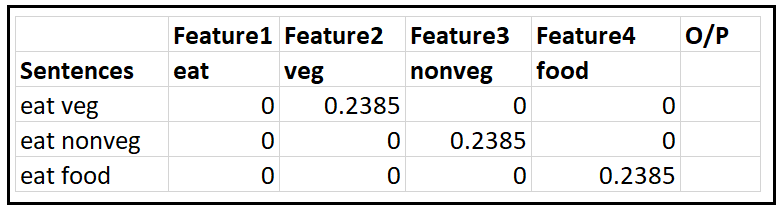

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=80)
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)

### Model maszyny wektorów nośnych

In [26]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report

svm_clf = SVC(C=2, kernel="linear", gamma="auto")
svm_clf.fit(X_train, y_train)

y_pred = svm_clf.predict(X_test)

print(f"Dokładność na zbiorze treningowym: {svm_clf.score(X_train, y_train)}")
print(f"Dokładność na zbiorze testowym: {svm_clf.score(X_test, y_test)}\n")
print(classification_report(y_test, y_pred, labels=[0, 1, 2]))

Dokładność na zbiorze treningowym: 0.8580750407830342
Dokładność na zbiorze testowym: 0.8441558441558441

              precision    recall  f1-score   support

           0       0.77      0.82      0.80        50
           1       0.80      0.78      0.79        46
           2       0.95      0.91      0.93        58

    accuracy                           0.84       154
   macro avg       0.84      0.84      0.84       154
weighted avg       0.85      0.84      0.85       154



**Opis klas:**
- 0: mieszkanie jest nieumeblowane
- 1: mieszkanie jest umeblowane
- 2: mieszkanie jest częściowo umeblowane

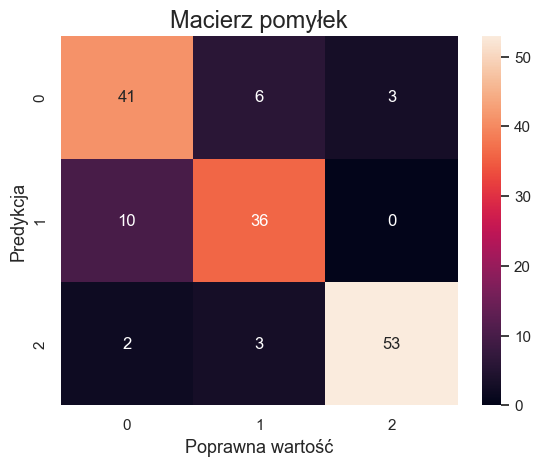

In [27]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
sns.heatmap(
    conf_matrix, annot=True, fmt="g", xticklabels=[0, 1, 2], yticklabels=[0, 1, 2]
)
plt.ylabel("Predykcja", fontsize=13)
plt.xlabel("Poprawna wartość", fontsize=13)
plt.title("Macierz pomyłek", fontsize=17)
plt.show()

### Model drzewa decyzyjnego

In [28]:
from sklearn.tree import DecisionTreeClassifier

dt_clf = DecisionTreeClassifier(criterion="gini", max_depth=3)

dt_clf.fit(X_train, y_train)

y_pred = dt_clf.predict(X_test)

print(f"Dokładność na zbiorze treningowym: {dt_clf.score(X_train, y_train)}")
print(f"Dokładność na zbiorze testowym: {dt_clf.score(X_test, y_test)}\n")
print(classification_report(y_test, y_pred, labels=[0, 1, 2]))

Dokładność na zbiorze treningowym: 0.8727569331158238
Dokładność na zbiorze testowym: 0.8961038961038961

              precision    recall  f1-score   support

           0       0.91      0.78      0.84        50
           1       0.85      0.96      0.90        46
           2       0.93      0.95      0.94        58

    accuracy                           0.90       154
   macro avg       0.90      0.89      0.89       154
weighted avg       0.90      0.90      0.89       154



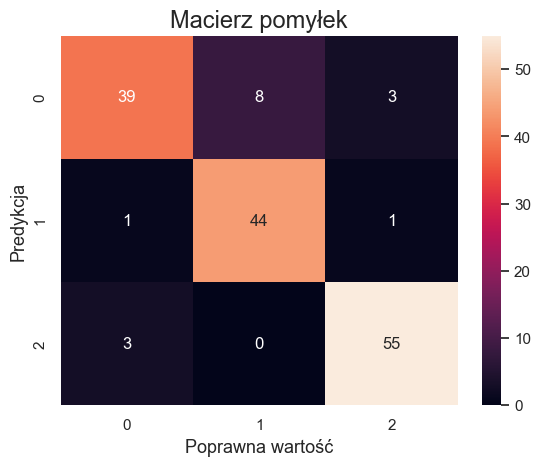

In [29]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
sns.heatmap(
    conf_matrix, annot=True, fmt="g", xticklabels=[0, 1, 2], yticklabels=[0, 1, 2]
)
plt.ylabel("Predykcja", fontsize=13)
plt.xlabel("Poprawna wartość", fontsize=13)
plt.title("Macierz pomyłek", fontsize=17)
plt.show()

### Model regresji logistycznej

In [30]:
from sklearn.linear_model import LogisticRegression

logreg_clf = LogisticRegression()
logreg_clf.fit(X_train, y_train)

y_pred = logreg_clf.predict(X_test)

print(f"Dokładność na zbiorze treningowym: {logreg_clf.score(X_train, y_train)}")
print(f"Dokładność na zbiorze testowym: {logreg_clf.score(X_test, y_test)}\n")
print(classification_report(y_test, y_pred, labels=[0, 1, 2]))

Dokładność na zbiorze treningowym: 0.8482871125611745
Dokładność na zbiorze testowym: 0.7857142857142857

              precision    recall  f1-score   support

           0       0.68      0.80      0.73        50
           1       0.80      0.72      0.76        46
           2       0.89      0.83      0.86        58

    accuracy                           0.79       154
   macro avg       0.79      0.78      0.78       154
weighted avg       0.80      0.79      0.79       154



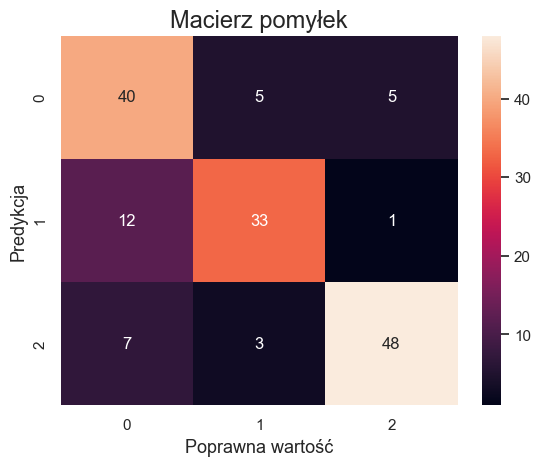

In [31]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
sns.heatmap(
    conf_matrix, annot=True, fmt="g", xticklabels=[0, 1, 2], yticklabels=[0, 1, 2]
)
plt.ylabel("Predykcja", fontsize=13)
plt.xlabel("Poprawna wartość", fontsize=13)
plt.title("Macierz pomyłek", fontsize=17)
plt.show()

### Model lasów losowych

In [32]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(100, max_depth=3, criterion="entropy")
rf_clf.fit(X_train, y_train)

y_pred = rf_clf.predict(X_test)

print(f"Dokładność na zbiorze treningowym: {rf_clf.score(X_train, y_train)}\n")
print(f"Dokładność na zbiorze testowym: {rf_clf.score(X_test, y_test)}")
print(classification_report(y_test, y_pred, labels=[0, 1, 2]))

Dokładność na zbiorze treningowym: 0.9151712887438825

Dokładność na zbiorze testowym: 0.8636363636363636
              precision    recall  f1-score   support

           0       0.79      0.82      0.80        50
           1       0.85      0.76      0.80        46
           2       0.93      0.98      0.96        58

    accuracy                           0.86       154
   macro avg       0.86      0.85      0.86       154
weighted avg       0.86      0.86      0.86       154



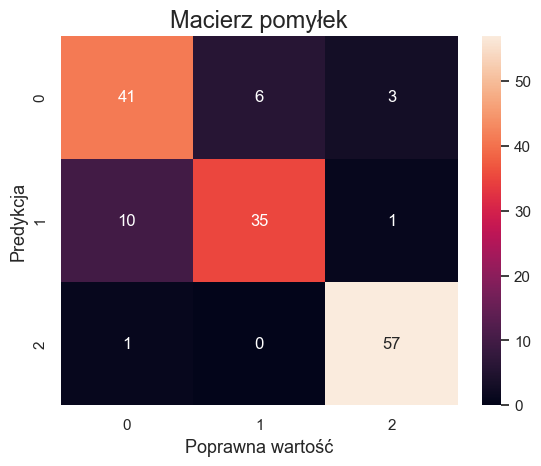

In [33]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
sns.heatmap(
    conf_matrix, annot=True, fmt="g", xticklabels=[0, 1, 2], yticklabels=[0, 1, 2]
)
plt.ylabel("Predykcja", fontsize=13)
plt.xlabel("Poprawna wartość", fontsize=13)
plt.title("Macierz pomyłek", fontsize=17)
plt.show()

## Wektoryzacja danych tekstowych z wykorzystaniem funkcji CountVectorizer
CountVectorizer przekształca listę opisów na macierz numeryczną, w której każdy wiersz odpowiada jednemu dokumentowi, a każda kolumna odpowiada jednemu unikalnemu słowu. Wartości w tej macierzy to liczby całkowite reprezentujące ile razy dany termin występuje w danym dokumencie.

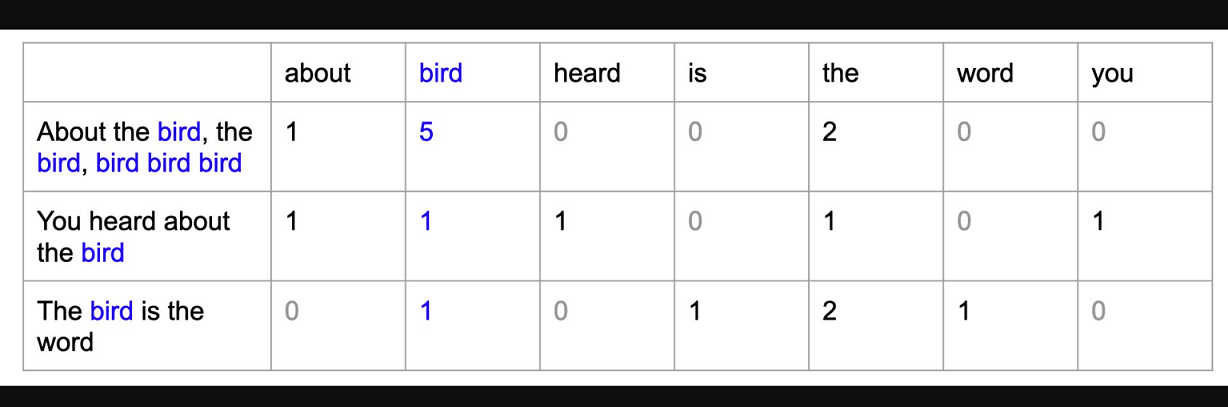

In [34]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()

In [35]:
X_train, X_test, y_train, y_test = train_test_split(
    df["Opis"], df["Label"], random_state=42, test_size=0.2, shuffle=True
)

count_vec = CountVectorizer()
X_train = count_vec.fit_transform(X_train)
X_test = count_vec.transform(X_test)

### Model drzewa decyzyjnego

In [36]:
dt_clf = DecisionTreeClassifier(criterion="gini", max_depth=3)

dt_clf.fit(X_train, y_train)

y_pred = dt_clf.predict(X_test)

print(f"Dokładność na zbiorze treningowym: {dt_clf.score(X_train, y_train)}")
print(f"Dokładność na zbiorze testowym: {dt_clf.score(X_test, y_test)}\n")
print(classification_report(y_test, y_pred, labels=[0, 1, 2]))

Dokładność na zbiorze treningowym: 0.8809135399673735
Dokładność na zbiorze testowym: 0.9090909090909091

              precision    recall  f1-score   support

           0       0.95      0.78      0.86        50
           1       0.83      0.96      0.89        46
           2       0.95      0.98      0.97        58

    accuracy                           0.91       154
   macro avg       0.91      0.91      0.90       154
weighted avg       0.91      0.91      0.91       154



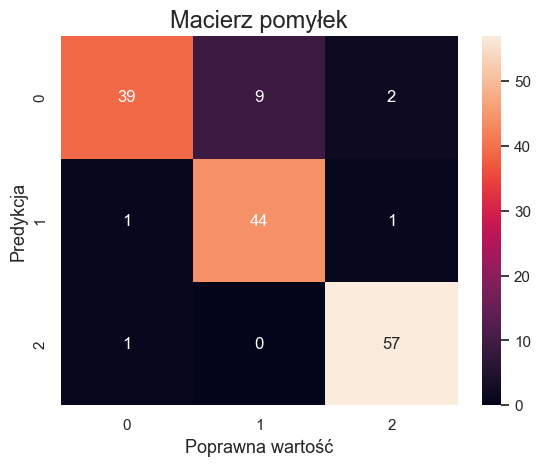

In [37]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
sns.heatmap(
    conf_matrix, annot=True, fmt="g", xticklabels=[0, 1, 2], yticklabels=[0, 1, 2]
)
plt.ylabel("Predykcja", fontsize=13)
plt.xlabel("Poprawna wartość", fontsize=13)
plt.title("Macierz pomyłek", fontsize=17)
plt.show()

### Model maszyny wektorów nośnych

In [38]:
svm_clf = SVC(C=3, kernel="linear", gamma="auto")
svm_clf.fit(X_train, y_train)

y_pred = svm_clf.predict(X_test)

print(f"Dokładność na zbiorze treningowym: {svm_clf.score(X_train, y_train)}")
print(f"Dokładność na zbiorze testowym: {svm_clf.score(X_test, y_test)}\n")
print(classification_report(y_test, y_pred, labels=[0, 1, 2]))

Dokładność na zbiorze treningowym: 1.0
Dokładność na zbiorze testowym: 0.8246753246753247

              precision    recall  f1-score   support

           0       0.76      0.76      0.76        50
           1       0.75      0.78      0.77        46
           2       0.95      0.91      0.93        58

    accuracy                           0.82       154
   macro avg       0.82      0.82      0.82       154
weighted avg       0.83      0.82      0.83       154



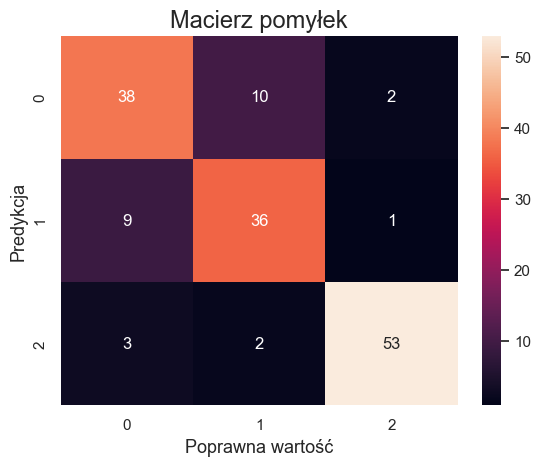

In [39]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
sns.heatmap(
    conf_matrix, annot=True, fmt="g", xticklabels=[0, 1, 2], yticklabels=[0, 1, 2]
)
plt.ylabel("Predykcja", fontsize=13)
plt.xlabel("Poprawna wartość", fontsize=13)
plt.title("Macierz pomyłek", fontsize=17)
plt.show()

## Wektoryzacja danych tekstowych z wykorzystaniem Bi-Gramów
W tym przypadku CountVectorizer będzie brał pod uwagę zarówno pojedyncze słowa, jak i pary sąsiadujących słów.

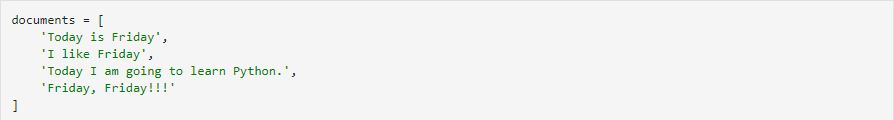
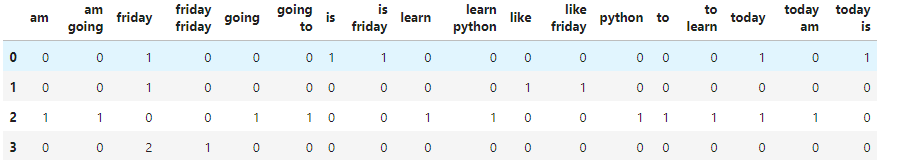

In [40]:
X_train, X_test, y_train, y_test = train_test_split(
    df["Opis"], df["Label"], random_state=42, test_size=0.2, shuffle=True
)

bigram = CountVectorizer(ngram_range=(1, 2))
X_train = bigram.fit_transform(X_train)
X_test = bigram.transform(X_test)

### Model drzewa decyzyjnego

In [41]:
dt_clf = DecisionTreeClassifier(criterion="gini", max_depth=3)

dt_clf.fit(X_train, y_train)

y_pred = dt_clf.predict(X_test)

print(f"Dokładność na zbiorze treningowym: {dt_clf.score(X_train, y_train)}")
print(f"Dokładność na zbiorze testowym: {dt_clf.score(X_test, y_test)}\n")
print(classification_report(y_test, y_pred, labels=[0, 1, 2]))

Dokładność na zbiorze treningowym: 0.8809135399673735
Dokładność na zbiorze testowym: 0.9025974025974026

              precision    recall  f1-score   support

           0       0.91      0.78      0.84        50
           1       0.83      0.96      0.89        46
           2       0.97      0.97      0.97        58

    accuracy                           0.90       154
   macro avg       0.90      0.90      0.90       154
weighted avg       0.91      0.90      0.90       154



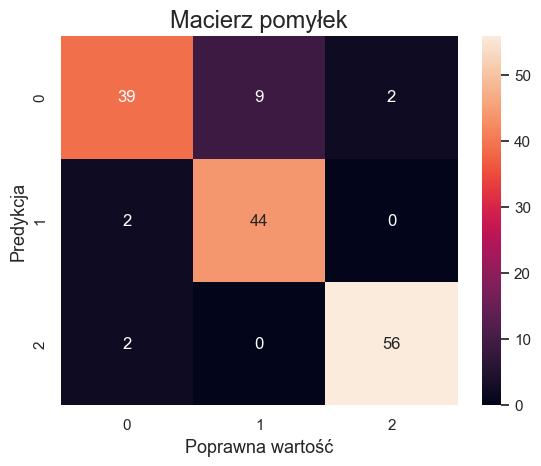

In [42]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
sns.heatmap(
    conf_matrix, annot=True, fmt="g", xticklabels=[0, 1, 2], yticklabels=[0, 1, 2]
)
plt.ylabel("Predykcja", fontsize=13)
plt.xlabel("Poprawna wartość", fontsize=13)
plt.title("Macierz pomyłek", fontsize=17)
plt.show()

### Model maszyny wektorów nośnych

In [43]:
svm_clf = SVC(C=3, kernel="linear", gamma="auto")
svm_clf.fit(X_train, y_train)

y_pred = svm_clf.predict(X_test)

print(f"Dokładność na zbiorze treningowym: {svm_clf.score(X_train, y_train)}")
print(f"Dokładność na zbiorze testowym: {svm_clf.score(X_test, y_test)}\n")
print(classification_report(y_test, y_pred, labels=[0, 1, 2]))

Dokładność na zbiorze treningowym: 1.0
Dokładność na zbiorze testowym: 0.8181818181818182

              precision    recall  f1-score   support

           0       0.71      0.80      0.75        50
           1       0.80      0.76      0.78        46
           2       0.94      0.88      0.91        58

    accuracy                           0.82       154
   macro avg       0.82      0.81      0.81       154
weighted avg       0.83      0.82      0.82       154



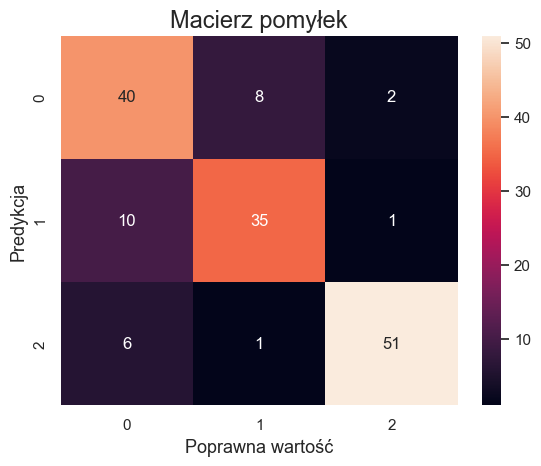

In [44]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
sns.heatmap(
    conf_matrix, annot=True, fmt="g", xticklabels=[0, 1, 2], yticklabels=[0, 1, 2]
)
plt.ylabel("Predykcja", fontsize=13)
plt.xlabel("Poprawna wartość", fontsize=13)
plt.title("Macierz pomyłek", fontsize=17)
plt.show()